OLD NOTEBOOK: SEE osm_pbf_power_data_extractor.py which does everything.

In [2]:
import os, sys, time

import requests
import shutil

# https://gitlab.com/dlr-ve-esy/esy-osmfilter/-/tree/master/
from esy.osmfilter import osm_colors as CC
from esy.osmfilter import run_filter, Node, Way, Relation
from esy.osmfilter import export_geojson
from contextlib import contextmanager

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import geoplot
import matplotlib.pyplot as plt

# import logging
# logging.basicConfig()
# logger=logging.getLogger(__name__)
# logger.setLevel(logging.INFO)
# logger.setLevel(logging.WARNING)

In [3]:
# geofabrik_regions = ["algeria","angola","benin","botswana","burkina_faso","burundi","cameroon","canary_islands","cape_verde","central_african_republic","chad","comores","congo_brazzaville","congo_democratic_republic","djibouti","egypt","equatorial_guinea","eritrea","ethiopia","gabon","ghana","guinea_bissau","guinea","ivory_coast","kenya","lesotho","liberia","libya","madagascar","malawi","mali","mauritania","mauritius","morocco","mozambique","namibia","niger","nigeria","rwanda","saint_helena_ascension_and_tristan_da_cunha","sao_tome_and_principe","senegal_and_gambia","seychelles","sierra_leone","somalia","south_africa_and_lesotho","south_africa","south_sudan","sudan","swaziland","tanzania","togo","tunisia","uganda","zambia","zimbabwe"]

In [8]:
country_name = "egypt"  # TODO: Create dictionary with country_code : country_name pairs
country_code = "egypt"
update = True  # prevents re-download and filteration of file
element_file_exists = True

# json file for the Data dictionary
# json file for the Elements dictionary is automatically written to 'data/osm/Elements'+filename)
JSON_outputfile = os.path.join(
    os.getcwd(), "data", "osm", country_name + "_generator.json"
)

if os.path.exists(JSON_outputfile):
    element_file_exists = True

geofabrik_filename = f"{country_name}-latest.osm.pbf"  # Filename for geofabrik
geofabrik_url = f"https://download.geofabrik.de/africa/{geofabrik_filename}"  # https://download.geofabrik.de/africa/nigeria-latest.osm.pbf

PBF_inputfile = os.path.join(
    os.getcwd(), "data", "osm", "pbf", geofabrik_filename
)  # Input filepath

if not os.path.exists(PBF_inputfile) or update or element_file_exists is False:
    print(f"{geofabrik_filename} does not exist, downloading to {PBF_inputfile}")
    os.makedirs(
        os.path.dirname(PBF_inputfile), exist_ok=True
    )  # create data/osm directory
    with requests.get(geofabrik_url, stream=True) as r:
        with open(PBF_inputfile, "wb") as f:
            shutil.copyfileobj(r.raw, f)

egypt-latest.osm.pbf does not exist, downloading to /home/max/OneDrive/PHD-Flexibility/07_pypsa-africa/0github/pypsa-africa/data_exploration/data/osm/pbf/egypt-latest.osm.pbf


In [9]:
print(PBF_inputfile, JSON_outputfile)

/home/max/OneDrive/PHD-Flexibility/07_pypsa-africa/0github/pypsa-africa/data_exploration/data/osm/pbf/egypt-latest.osm.pbf /home/max/OneDrive/PHD-Flexibility/07_pypsa-africa/0github/pypsa-africa/data_exploration/data/osm/egypt_generator.json


In [10]:
# see https://dlr-ve-esy.gitlab.io/esy-osmfilter/filter.html for filter structures

prefilter = {
    Node: {"power": ["generator"]},
    Way: {"power": ["generator"]},
    Relation: {"power": ["generator"]},
}
blackfilter = [
    ("pipeline", "generator"),
]  # HACKY: due to esy.osmfilter
whitefilter = [
    [
        ("power", "generator"),
    ],
]

elementname = f"{country_code}_substations"

if update is False or element_file_exists is False:
    create_elements = False  # Do not create elements again
    new_prefilter_data = False  # Do not pre-filter data again
    print("Loading Pickle")
else:
    create_elements = True  # Do not create elements again
    new_prefilter_data = True  # Do not pre-filter data again
    print("Creating  New Elements")

[Data, Elements] = run_filter(
    elementname,
    PBF_inputfile,
    JSON_outputfile,
    prefilter,
    whitefilter,
    blackfilter,
    NewPreFilterData=new_prefilter_data,
    CreateElements=create_elements,
    LoadElements=True,
    verbose=False,
    multiprocess=True,
)

# export the elements to a geojson-file
# export_geojson(Elements[elementname]['Way'],Data,filename='test.geojson',jsontype='Line')
# convert extract node elements
# export_geojson(Elements[elementname]['Node'],Data,filename='test.geojson',jsontype='Point')

Creating  New Elements


In [81]:
df_way = pd.json_normalize(Elements[elementname]["Node"].values())
# df_way.dropna(subset=['tags.voltage'], inplace = True) # Drop any substations with Voltage = N/A
# na_values_voltage = df_way.isna().sum()
# df_way.dropna(thresh=len(df_way)*0.25, axis=1, how='all', inplace = True) #Drop Columns with 75% values as N/A
df_way.drop(
    columns=["tags.fixme", "tags.frequency", "tags.generator:output:electricity"],
    inplace=True,
    errors="ignore",
)
# df_way.drop(columns = "tags.frequency", inplace = True)
display(df_way)
df_way.lonlat

col = "refs"
df_way[col] = pd.Series() if col not in df_way.columns else df_way[col]
df_way

,id,lonlat,tags.power,tags.generator:type,tags.generator:method,tags.generator:source,tags.name,tags.website
0,2778311874,"[32.5742078999999, 29.194876299999898]",generator,horizontal_axis,wind_turbine,wind,NaN,NaN
1,2778313207,"[32.58443139999978, 29.25162609999989]",generator,horizontal_axis,wind_turbine,wind,NaN,NaN
2,2778314209,"[32.58563729999979, 29.285182199999873]",generator,horizontal_axis,wind_turbine,wind,NaN,NaN
3,7546558622,"[31.607156400000044, 31.442591099999877]",generator,gas_turbine,combustion,gas,NaN,NaN
4,2778311784,"[32.54769679999989, 29.194424699999896]",generator,horizontal_axis,wind_turbine,wind,NaN,NaN
...,...,...,...,...,...,...,...,...
1247,2778312168,"[32.55120339999989, 29.2061722999999]",generator,horizontal_axis,wind_turbine,wind,NaN,NaN
1248,1316378303,"[32.61208629999999, 29.179384700000004]",generator,horizontal_axis,wind_turbine,wind,Zafarana 3,NaN
1249,7550313563,"[33.156802600000006, 28.112376399999842]",generator,vertical_axis,wind_turbine,wind,NaN,NaN
1250,4267947712,"[33.14870870000006, 28.16227589999995]",generator,vertical_axis,wind_turbine,wind,El-Zayt wind farm,NaN


/home/max/anaconda3/envs/pypsa-africa/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # This is added back by InteractiveShellApp.init_path()


,id,lonlat,tags.power,tags.generator:type,tags.generator:method,tags.generator:source,tags.name,tags.website,refs
0,2778311874,"[32.5742078999999, 29.194876299999898]",generator,horizontal_axis,wind_turbine,wind,NaN,NaN,NaN
1,2778313207,"[32.58443139999978, 29.25162609999989]",generator,horizontal_axis,wind_turbine,wind,NaN,NaN,NaN
2,2778314209,"[32.58563729999979, 29.285182199999873]",generator,horizontal_axis,wind_turbine,wind,NaN,NaN,NaN
3,7546558622,"[31.607156400000044, 31.442591099999877]",generator,gas_turbine,combustion,gas,NaN,NaN,NaN
4,2778311784,"[32.54769679999989, 29.194424699999896]",generator,horizontal_axis,wind_turbine,wind,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1247,2778312168,"[32.55120339999989, 29.2061722999999]",generator,horizontal_axis,wind_turbine,wind,NaN,NaN,NaN
1248,1316378303,"[32.61208629999999, 29.179384700000004]",generator,horizontal_axis,wind_turbine,wind,Zafarana 3,NaN,NaN
1249,7550313563,"[33.156802600000006, 28.112376399999842]",generator,vertical_axis,wind_turbine,wind,NaN,NaN,NaN
1250,4267947712,"[33.14870870000006, 28.16227589999995]",generator,vertical_axis,wind_turbine,wind,El-Zayt wind farm,NaN,NaN


In [76]:
df_way = pd.json_normalize(Elements[elementname]["Way"].values())
# df_way.dropna(subset=['tags.voltage'], inplace = True) # Drop any substations with Voltage = N/A
# na_values_voltage = df_way.isna().sum()
# df_way.dropna(thresh=len(df_way)*0.25, axis=1, how='all', inplace = True) #Drop Columns with 75% values as N/A
df_way.drop(columns="tags.frequency", inplace=True)
df_way.drop(columns="tags.barrier", inplace=True)
df_way.drop(columns="tags.building", inplace=True)
df_way.drop(columns="tags.name:ar", inplace=True)
# display(df_way)

# df[df['ids'].str.contains("ball")]
df_way = df_way[
    df_way["tags.generator:output:electricity"].astype(str).str.contains("MW")
]  # .filter(like = 'MW', axis = 1)#.astype(str).apply(lambda x: x.contains('MW'))
df_way["tags.generator:output:electricity"].str.extract("(\d+)").astype(int)

,0
2,400
10,400
16,400
27,400
28,320
30,400
41,400
43,400
47,400
53,320


In [14]:
# # Convert Ways to Nodes
# lonlat_column =[]
# for ref in df_way["refs"]:
#     lonlats =[]
#     for r in ref:
#         lonlat = Data["Node"][str(r)]["lonlat"]
#         lonlats.append(lonlat)
#     lonlats = np.array(lonlats)
#     lonlat = np.mean(lonlats, axis=0) #Hacky Apporx Centroid
#     lonlat_column.append(lonlat)
# df_way.drop('refs',axis=1,inplace=True)
# df_way.insert(1, "lonlat", lonlat_column)
# display(df_way)

# # polygon_column=[]
# # for poly_list in lonlat_column:
# #     for p in poly_list:
# #         print(p)

# #     print("p")

In [15]:
# pd.merge(df_way, df_way1, on='id')#,'tags.generator:type','tags.power','tags.generator:method','tags.generator:source'])#,  'tags.generator:source','tags.generator:output:electricity', 'tags.name'])#, on=["STATION", "DATE"])

# #df_way.columns[:8]

In [20]:
gdf = gpd.GeoDataFrame(df_way, geometry=[Point(x, y) for x, y in df_way.lonlat])
gdf.drop(columns=["lonlat"], inplace=True)
display(gdf)

,id,tags.power,tags.generator:type,tags.generator:method,tags.generator:source,tags.generator:output:electricity,tags.name,tags.website,geometry
0,7550318769,generator,gas_turbine,combustion,gas,25 MW,NaN,NaN,POINT (30.52888 31.17642)
1,2778312747,generator,horizontal_axis,wind_turbine,wind,NaN,NaN,NaN,POINT (32.58340 29.23462)
2,4267947597,generator,vertical_axis,wind_turbine,wind,2 MW,El-Zayt wind farm,NaN,POINT (33.16924 28.12326)
3,7546558609,generator,steam_turbine,combustion,gas,300 MW,NaN,NaN,POINT (32.47168 29.93673)
4,7546558682,generator,steam_turbine,combustion,gas,250 MW,NaN,http://www.cairoepc.com/EN/cnorth.html,POINT (31.26869 30.10777)
...,...,...,...,...,...,...,...,...,...
1247,2778311876,generator,horizontal_axis,wind_turbine,wind,850 kW,NaN,NaN,POINT (32.57659 29.19493)
1248,1316378133,generator,horizontal_axis,wind_turbine,wind,600 kW,Zafarana 1,NaN,POINT (32.62513 29.16533)
1249,2778314498,generator,horizontal_axis,wind_turbine,wind,NaN,NaN,NaN,POINT (32.57423 29.29598)
1250,1316378300,generator,horizontal_axis,wind_turbine,wind,NaN,NaN,NaN,POINT (32.59080 29.22367)


In [21]:
GeoJSON_outputfile = os.path.join(
    os.getcwd(), "data", "osm", country_name + "_generators.geojson"
)
gdf.to_file(GeoJSON_outputfile, driver="GeoJSON")

In [22]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
saudi = world.query('name == "Saudi Arabia"')
yemen = world.query('name == "Yemen"')
iraq = world.query('name == "Iraq"')
oman = world.query('name == "Oman"')
uae = world.query('name == "United Arab Emirates"')
jordan = world.query('name == "Jordan"')
palestine = world.query('name == "Palestine"')
israel = world.query('name == "Israel"')
qatar = world.query('name == "Qatar"')
kuwait = world.query('name == "Kuwait"')
mena = (
    saudi.append(yemen)
    .append(iraq)
    .append(oman)
    .append(uae)
    .append(jordan)
    .append(palestine)
    .append(israel)
    .append(qatar)
    .append(kuwait)
)
africa = world.query('continent == "Africa"').append(mena)

In [25]:
url = "https://development-data-hub-s3-public.s3.amazonaws.com/ddhfiles/144823/africagrid20170906final.geojson"
africa_network = gpd.read_file(url)
africa_generators = gpd.read_file(GeoJSON_outputfile)

<AxesSubplot:>

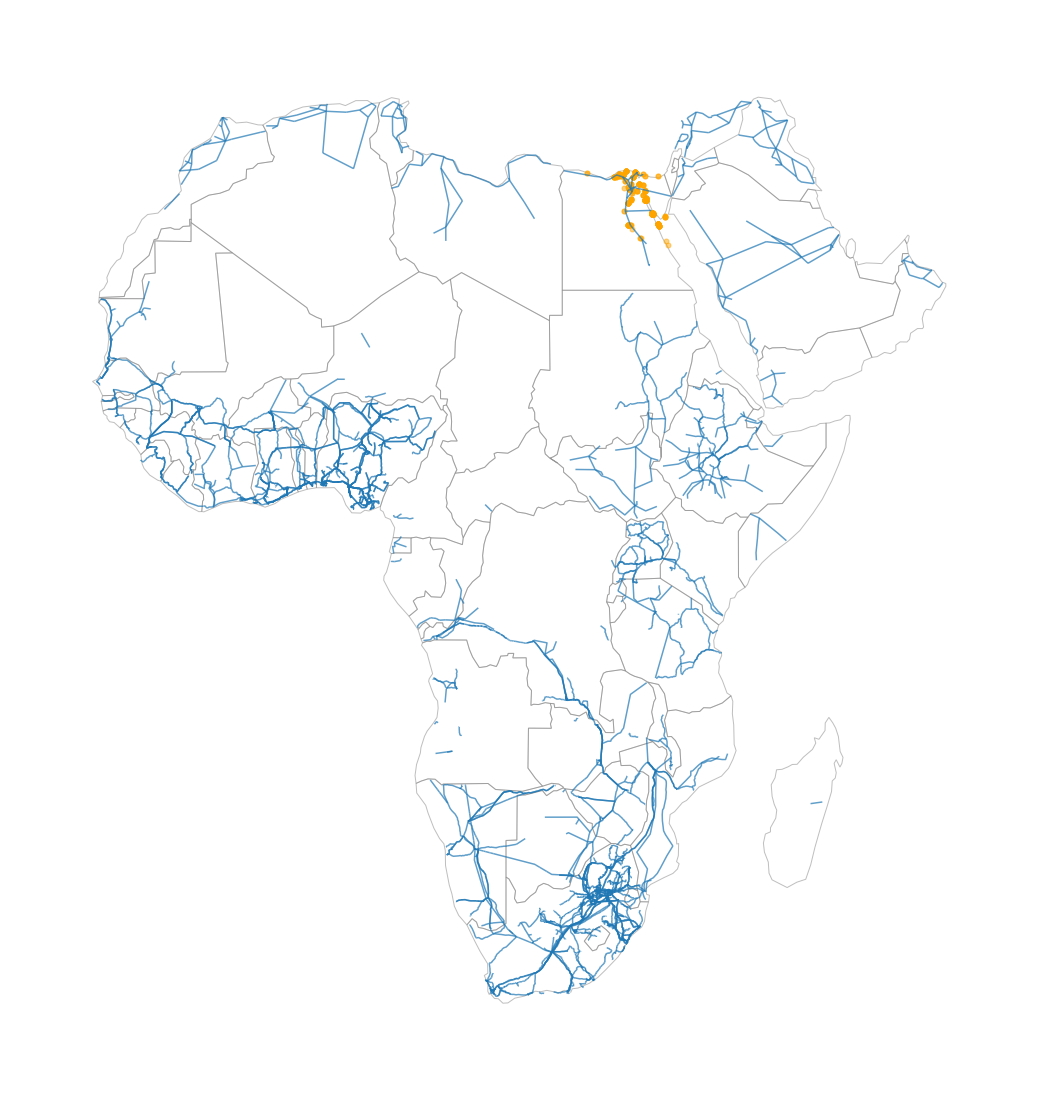

In [26]:
ax = africa_network[africa_network.voltage_kV > 110].plot(figsize=(20, 20), alpha=0.7)
geoplot.polyplot(africa, edgecolor="grey", ax=ax, alpha=0.5)
africa_substations.plot(
    figsize=(20, 20), markersize=25, color="orange", alpha=0.5, ax=ax
)
# plt.savefig('africa_transmission_and substations_110.png')